#  <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Homework 7: Classification with Logistic Regression, LDA/QDA, and Trees


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

<div class='exercise'><b> Question 1 [20 pts]: Overview of Multiclass Thyroid Classification </b></div>

In this problem set you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw7.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was [obtained from the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Thyroid+Disease); for this assignment we chose two predictors so we can visualize the decision boundaries.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore different methods for multiclass classification.

For most of this problem set, we'll measure overall classification accuracy as the fraction of observations classified correctly.

**1.1** Load the data and examine its structure. How many instances of each class are there in our dataset? In particular, what is the ratio of the number of observations in class 2 (hyperthyroidism) to the number of observations in class 3 (hypothyroidism)? We'll refer to this as the *hyper-to-hypo ratio*.

**1.2**: We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on your plot, also mark the hyper-to-hypo ratio that you found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved (the code is provided). Make a table showing how many observations of each class ended up in your training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? Assign the result to `baseline_accuracy` so we can use it later. (**note: don't look at the test set until instructed**)

**1.6** Make a decision function to separate these samples using no library functions; just write out your logic by hand. Your manual classifier doesn't need to be well-tuned (we'll be exploring algorithms to do that!); it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function provided above to overlay the decision boundaries of your function on the training set. (Note that the function modifies an existing plot, so call it after plotting your points.)

Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead you to these conclusions?

**1.1**

In [3]:
# your code here
df = pd.read_csv('./dataset_hw7.csv')
df.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1
1,0.693152,0.262372,1
2,0.262372,0.405472,1
3,-0.105349,1.064714,1
4,0.000010,1.131405,1


Text(0.5,1,'Number of observation by class')

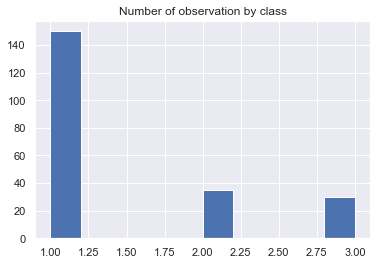

In [4]:
# your code here
plt.hist(df.Diagnosis)
plt.title('Number of observation by class')

In [5]:
class_counts = df.Diagnosis.value_counts()
Hyper_to_hypo = class_counts[2]/class_counts[3]
print("Hyper_to_hypo ratio:",Hyper_to_hypo)

Hyper_to_hypo ratio: 1.1666666666666667


**1.2**

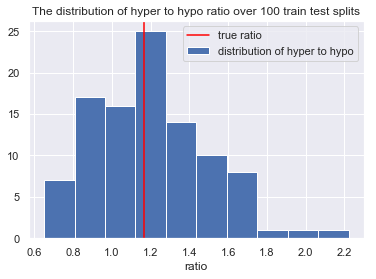

In [6]:
# your code here
df_train_100 = [train_test_split(df, test_size=0.5)[0] for _ in range(100)]
def get_hyper_to_hypo(df):
    class_counts = df.Diagnosis.value_counts()
    return class_counts[2]/class_counts[3]
hyper_to_hypo_100 = [get_hyper_to_hypo(df_train) for df_train in df_train_100]
plt.hist(hyper_to_hypo_100, label = 'distribution of hyper to hypo')
plt.axvline(Hyper_to_hypo, color = 'red', label = 'true ratio')
plt.xlabel('ratio')
plt.title('The distribution of hyper to hypo ratio over 100 train test splits')
plt.legend()
plt.show()

**your answer here**

There is large variation in the ratio, which suggests that the random splits lead to datasets that are not representative of the original distribution of classes.

**1.3**

In [7]:
data_train, data_test = train_test_split(df, test_size=.5, stratify=df.Diagnosis, random_state=99);

In [8]:
# your code here
class_dist = pd.DataFrame({'class_dist_train':data_train.Diagnosis.value_counts(),
                           'class_dist_test':data_test.Diagnosis.value_counts()})
class_dist

,class_dist_train,class_dist_test
1,75,75
2,17,18
3,15,15


In [9]:
# your code here
print('hyper to hypo in training set', get_hyper_to_hypo(data_train))
print('hyper to hypo in training set', get_hyper_to_hypo(data_test))

hyper to hypo in training set 1.1333333333333333
hyper to hypo in training set 1.2


**1.4**

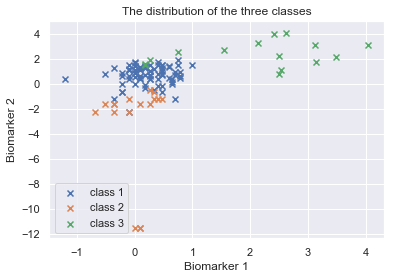

In [10]:
# your code here
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('The distribution of the three classes')
plt.show()

**1.5**

In [11]:
train_class_dist = class_dist.class_dist_train

In [12]:
train_class_dist.iloc[train_class_dist.values.argmax()]

75

In [13]:
# your code here
train_class_dist = data_train.Diagnosis.value_counts()
baseline_accuracy = train_class_dist.iloc[train_class_dist.values.argmax()]/np.sum(train_class_dist)
print('the baseline accuracy is',baseline_accuracy)

the baseline accuracy is 0.7009345794392523


**1.6**

In [14]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier (has a `.predict` method)
    X: feature vectors
    y: ground-truth classes
    colors: list of colors to use. Use color colors[i] for class i.
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    """
    # Create mesh
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points
    if hasattr(model, 'predict'):
        model = model.predict
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        colors = sns.utils.get_color_cycle()
        y -= y.min() # If first class is not 0, shift.
    assert np.max(y) <= len(colors)
    colors = [sns.utils.desaturate(color, desaturate) for color in colors]
    cmap = matplotlib.colors.ListedColormap(colors)

    # Plot decision surface
#    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    ax.contourf(xx, yy, y,zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=3)
    ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    ax.grid(False)

In [15]:
# Update the following function:
def predict_manual_one_sample(x):
    if x[1] > -2*x[0]+4:
        return 3
    if x[1] < -1:
        return 2
    else:
        return 1

In [16]:
X, y = data_train.values[:,:-1], data_train.values[:,-1]

In [17]:
def predict_manual(X):
    return np.array([predict_manual_one_sample(x) for x in X])

manual_predictions = predict_manual(X)
accuracy = accuracy_score(y, manual_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9252336448598131


In [18]:
assert accuracy >= (baseline_accuracy * 1.10), "Accuracy too low"
assert all(np.sum(manual_predictions == i) > 0 for i in [1, 2, 3]), "Should predict each class at least once."

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


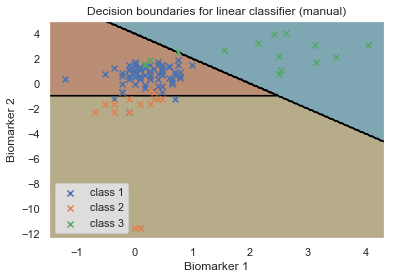

In [19]:
# Your code here
# your code here
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for linear classifier (manual)')
ax = plt.axes()
overlay_decision_boundary(ax, predict_manual)

**Your answer here**


Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead you to these conclusions?

I achieved above 85% with a linear classifer, so yes. I'm unsure about test set performance. I think a non-linear classifer could definitely do better on the training set, since with enough non-linearities, it could perfectly identify all the points. This would risk over fitting, which would ultimately hurt test set performance.

<div class='exercise'><b> Question 2 [20 pts]: Multiclass Logistic Regression</b></div>



**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.

**2.2** Interpret the decision boundaries:
- Do these decision boundaries make sense?
- What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?
- How do the different models treat regions where there are few samples? How do they classify such samples?

**2.3** Compare the performance of the two logistic regression models above using 5-fold cross-validation. Which model performs best? How confident are you about this conclusion? Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms? Why do you suspect it is better or worse?

*Hint*: You may use the `cross_val_score` function for cross-validation.

**2.1**

*Hint*: You should use `LogisticRegressionCV`. For the model with quadratic and interaction terms, use the following Pipeline:

In [20]:
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(cv = 5, multi_class="multinomial", max_iter=1000))

# Note that you can access the logistic regression classifier itself by
# polynomial_logreg_estimator.named_steps['logisticregressioncv']

In [21]:
# your code here
model_lin = LogisticRegressionCV(cv=5).fit(X, y)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


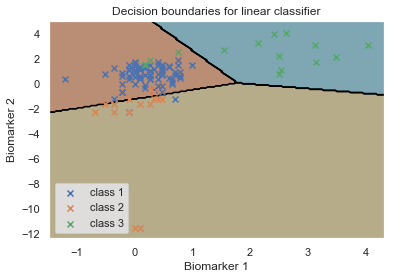

In [22]:
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for linear classifier')
ax = plt.axes()
overlay_decision_boundary(ax, lambda X: model_lin.predict(X)+1, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


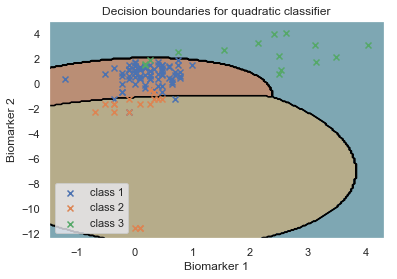

In [23]:
# your code here
model_quad = polynomial_logreg_estimator.fit(X, y)
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for quadratic classifier')
ax = plt.axes()
overlay_decision_boundary(ax, model_quad, colors=None, nx=200, ny=200, desaturate=.5)

**2.2**

**Your answer here**

**Do these decision boundaries make sense?**

They make sense with respect to the training data, although it is unclear whether they would generalize to out of sample data. The classifiers are performing as expected, with lines seperating the data in the linear classifier and parabolas seperating the data when quadratic and interaction terms are included.

**What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?**

The decision boundaries become parabolas because they are functions of order two terms.

**How do the different models treat regions where there are few samples? How do they classify such samples?**

The classifiers treat the regions with few samples differently. The linear classifier could predict any one of the classes depending on where the sample is located on the plane. The quadratic classifier would predict class 3 if the sample is far enough away from the origin.

**2.3**

In [24]:
# your code here
linear_cv = cross_val_score(LogisticRegressionCV(cv=5), X, y =y, cv = 5)
print("the linear model's cross validated accuracy is", np.mean(linear_cv))

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option

the linear model's cross validated accuracy is 0.9168831168831169


In [25]:
# your code here
quad_cv = cross_val_score(polynomial_logreg_estimator, X, y = y, cv = 5)
print("the quadratic model's cross validated accuracy is", np.mean(quad_cv))

the quadratic model's cross validated accuracy is 0.8974025974025974


In [26]:
np.var(linear_cv)

0.001890144487547082

In [27]:
np.var(quad_cv)

0.00028785067746106693

**Your answer here**

**Which model performs best? **

The linear model performs better.

**How confident are you about this conclusion?**

I am not very confident about this result because since there is such a high class inbalance, doing cross validation on an already split dataset leads to very few samples from the minority class. This means that higher variance models might appear to perform worse, but if we included the full dataset without cross validation, the additional samples would lead to greater stability and less over fitting.

**Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms?**

The polynomial terms lead to worse accuracy.

**Why do you suspect it is better or worse?**

The polynomial terms cause the model to overfit.

<div class='exercise'><b> Question 3 [20 pts]: Discriminant Analysis</b></div>



**3.1** Consider the following synthetic dataset with two classes. A green star marks a test observation; which class do you think it belongs to? How would LDA classify that observation? How would QDA? Explain your reasoning.

**3.2** Now let's return to the thyroid dataset. Make a table of the total variance of each class for each biomarker.

**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?

**3.1**

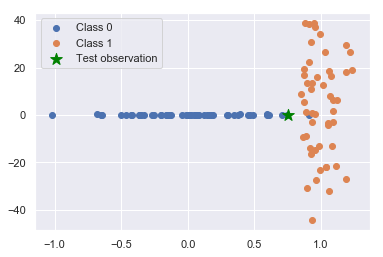

In [28]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.legend();

<font color = 'red'> **ASK FOR HELP** </font>

**Your answer here**
**Which class do you think it belongs to?**
I think it belongs to class 0 because its second component is 0, like all other samples from that class.

**How would LDA classify that observation? How would QDA? Explain your reasoning.**

LDA would classify the observation as class 0 because, overall, class 0 has less variance than class 1. QDA would classify the point as class 1 because class 1 has less variance in the x dimension.

**3.2**

In [29]:
# your code here
data_train.groupby('Diagnosis').var()

,Biomarker 1,Biomarker 2
Diagnosis,,
1,0.134103,0.607021
2,0.120058,15.734945
3,1.537893,0.963413


**3.3**

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


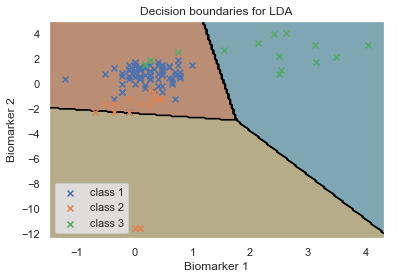

In [30]:
# your code here
model_LDA = LinearDiscriminantAnalysis().fit(X, y)
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for LDA')
ax = plt.axes()
overlay_decision_boundary(ax, model_LDA, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


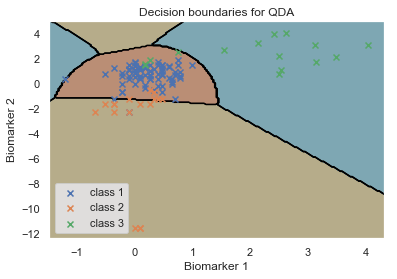

In [31]:
model_QDA = QuadraticDiscriminantAnalysis().fit(X, y)
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for QDA')
ax = plt.axes()
overlay_decision_boundary(ax, model_QDA)

**Your answer here**

**Comment on how the decision boundaries differ.**

LDA has linear boundaries whereas the boundaries in QDA are non linear. Also the regions for each class are all connected for LDA, whereas this is not the case for QDA.

**How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?**

The high variance of class 2 and 3 relative to class 1 has a large effect on the boundaries, especially in QDA. Since the variance for classes 2 and 3 are larger, the standard deviation of their predicted underlying normal distribution is also large. This means that near the class 1 samples, class 1 is predicted, but faraway from class 1, the other two class are predicted, even if the class 1 samples are closer.

<div class='exercise'> <b> Question 4 [20 pts]: Fit Decision Trees </b> </div> 


We next try out decision trees for thyroid classification. For the following questions, you should use the *Gini* index as the splitting criterion while fitting the decision tree. 

*Hint:* You should use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth.



**4.1**. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the accuracy as a function of the maximum tree depth, on the training set and the mean score on the validation sets for 5-fold CV. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about how this tree will generalize? Which hyperparameter setting gives the best cross-validation performance?

**4.2**: Visualize the decision boundaries of the best decision tree you just fit. How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? Given an explanation for your observation.

**4.3** Explain *in words* how the best fitted model diagnoses 'hypothyroidism' for a new patient. You can use the code below to examine the structure of the best decision tree.

**4.1**

In [32]:
# your code here
from sklearn.model_selection import GridSearchCV
depths = list(range(2,10))
params = {'max_depth' : depths}
model_tree = GridSearchCV(DecisionTreeClassifier(), param_grid = params, cv = 5).fit(X,y)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0.5,1,'5 fold cv to fit tree depth for decision tree')

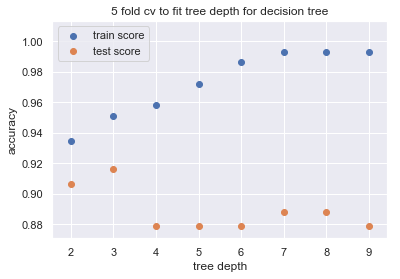

In [33]:
plt.scatter(depths, model_tree.cv_results_['mean_train_score'], label = 'train score')
plt.scatter(depths, model_tree.cv_results_['mean_test_score'], label = 'test score')
plt.legend()
plt.xlabel('tree depth')
plt.ylabel('accuracy')
plt.title('5 fold cv to fit tree depth for decision tree')

**Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set?**

Yes, at depth 7.

**If so, what can you say about how this tree will generalize?**

It would generalize poorly because it's overfitting the data.

**Which hyperparameter setting gives the best cross-validation performance?**

The best performance is achieved at depth 3.

**4.2**

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


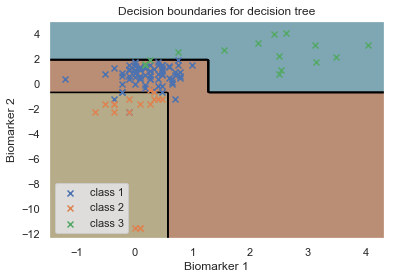

In [34]:
# your code here
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for decision tree')
ax = plt.axes()
overlay_decision_boundary(ax, model_tree)

**Your answer here**
**How are the shapes of the decision boundaries for this model different from the other methods we have seen so far?**

They are lines that meet at right angles.

**Give an explanation for your observation.**

Each split in the decision tree is based off of a single variable, which leads to the sharp bends in the decision boundary.

**4.3**

*Entirely optional note:* You can also generate a visual representation using the `export_graphviz`. However, viewing the generated GraphViz file requires additional steps. One approach is to paste the generated graphviz file in the text box at http://www.webgraphviz.com/. Alternatively, you can run GraphViz on your own computer, but you may need to install some additional software. Refer to the [Decision Tree section of the sklearn user guide](http://scikit-learn.org/stable/modules/tree.html#classification) for more information.

In [35]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [36]:
# your code here
show_tree_structure(model_tree.best_estimator_)

The binary tree structure has 11 nodes:

node 0: if X[:, 1] <= -0.693 then go to node 1, else go to node 6
  node 1: if X[:, 0] <= 0.582 then go to node 2, else go to node 5
    node 2: if X[:, 0] <= -0.053 then go to node 3, else go to node 4
      node 3: predict class 2.0
      node 4: predict class 2.0
    node 5: predict class 1.0
  node 6: if X[:, 0] <= 1.270 then go to node 7, else go to node 10
    node 7: if X[:, 1] <= 1.879 then go to node 8, else go to node 9
      node 8: predict class 1.0
      node 9: predict class 3.0
    node 10: predict class 3.0


One should diagnose hypothyroidism in two cases. If biomarker 1 is greater than 1.3, then biomarker 2 must be greater than -0.7 **or** if biomarker 1 is less than 1.3, biomarker 2 must be greater than 1.9.

<div class='exercise'><b> Question 5 [18 pts]: k-NN and Model comparison </b> </div>

We have now seen six different ways of fitting a classification model: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **decision trees**, and in this problem we'll add **k-NN**. Which of these methods should we use in practice for this problem? To answer this question, we now compare and contrast these methods.



**5.1** Fit a k-NN classifier with uniform weighting to the training set. Use 5-fold CV to pick the best $k$.

*Hint: Use `KNeighborsClassifier` and `cross_val_score`.*

**5.2** Plot the decision boundaries for each of the following models that you fit above. For models with hyperparameters, use the values you chose using cross-validation.
- Logistic Regression (linear)
- Logistic Regression (polynomial)
- Linear Discriminant Analysis 
- Quadratic Discriminant Analysis
- Decision Tree
- k-NN

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Quadratic logistic regression; QDA.
- k-NN and whichever other model has the most complex decision boundaries

**5.3** Describe how each model classifies an observation from the test set in one short sentence for each (assume that the model is already fit). For example, for the linear regression classifier you critiqued in hw5, you might write: "It classifies the observation as class 1 if the dot product of the feature vector with the the model coefficients (with constant added) exceeds 0.5."

- Logistic Regression (One-vs-Rest)
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- k-Nearest-Neighbors Classifier
- Decision Tree

**5.4** Estimate the validation accuracy for each of the models. Summarize your results in a graph or table. (Note: for some models you have already run these computations; it's ok to redo them here if it makes your code cleaner.)

**5.5** Based on everything you've found in this question so far, which model would you expect to perform best on our test data? 

Now evaluate each fitted model's performance on the test set. Also, plot the same decision boundaries as above, but now showing the test set. How did the overall performance compare with your performance estimates above? Which model actually performed best? Why do you think this is the case?

**5.6**. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Interpretability

If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.

**5.1**

In [37]:
# your code here
scores = {}
for k in range(1,30):
    scores[k] = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors = k), X, y, cv = 5))

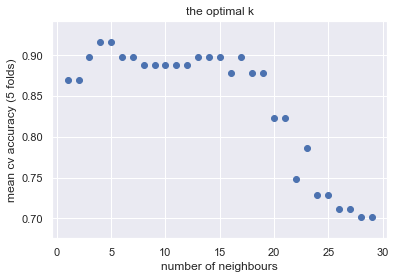

In [38]:
plt.scatter(scores.keys(), scores.values())
plt.xlabel('number of neighbours')
plt.ylabel('mean cv accuracy (5 folds)')
plt.title('the optimal k')
plt.show()

The optimal k is 5.

**5.2**

**Linear Classifiers**

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


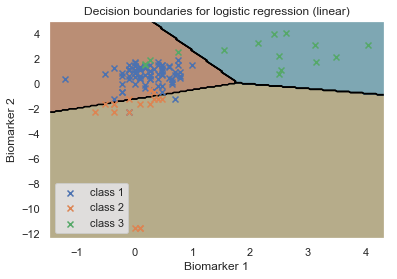

In [39]:
# Your code here
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for logistic regression (linear)')
ax = plt.axes()
overlay_decision_boundary(ax, lambda X: model_lin.predict(X)+1, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


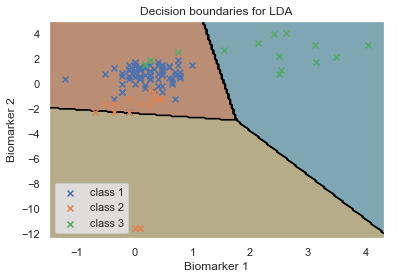

In [40]:
# your code here
model_LDA = LinearDiscriminantAnalysis().fit(X, y)
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for LDA')
ax = plt.axes()
overlay_decision_boundary(ax, model_LDA, colors=None, nx=200, ny=200, desaturate=.5)

LDA overselects class 1 whereas logistic regression fits the decision boundaries to class 1 more tightly. This makes sense because LDA takes the low variance of class 1 into account.

**Quadratic classifiers**

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


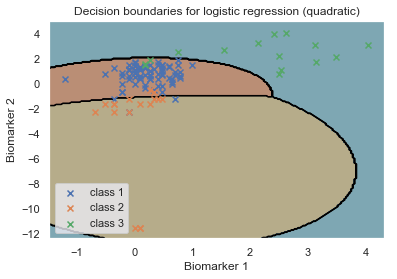

In [41]:
# Your code here
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for logistic regression (quadratic)')
ax = plt.axes()
overlay_decision_boundary(ax, lambda X: model_quad.predict(X)+1, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


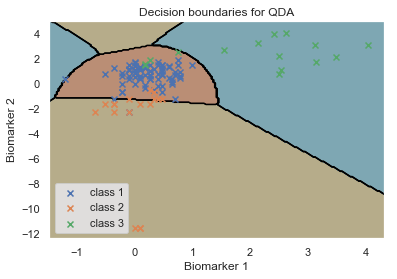

In [42]:
model_QDA = QuadraticDiscriminantAnalysis().fit(X, y)
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for QDA')
ax = plt.axes()
overlay_decision_boundary(ax, model_QDA)

QDA fits very tightly around class 1, whereas logistic regression with quadratic terms fits a wider region. QDA also predicts class 2 for when biomarker 2 is greater than 2, even though biomarker 1 is closer. The reason for these differences is that QDA takse the variances of the samples into account, whereas logistic regression with quadratic terms tries to divide the regions to minimize misclassifications.

**complex decision boundary**

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


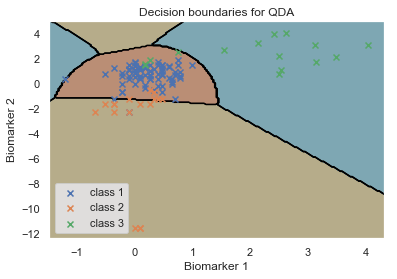

In [43]:
model_QDA = QuadraticDiscriminantAnalysis().fit(X, y)
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for QDA')
ax = plt.axes()
overlay_decision_boundary(ax, model_QDA)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


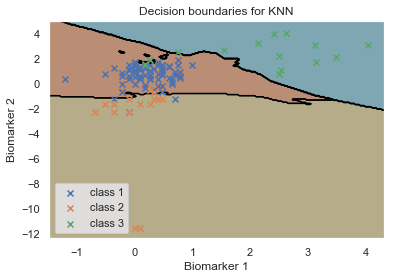

In [44]:
model_knn = KNeighborsClassifier(n_neighbors = 5).fit(X, y)
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for KNN')
ax = plt.axes()
overlay_decision_boundary(ax, model_knn)

While the KNN model has a complicated decision boundary on a small scale, overall it is quite similar to the decision boundary predicted by a basic logistic regression. KNN is has a simple decision boundary at the macro level because the samples are relatively well seperated, which naturally results in straight lines determining nearest neighbours.

QDA on the other hand, has a very smooth decision boundary, but it's segmented structure leads to a different type of complexity on a macro scale. QDA assumes a guassian mixture model as the data generating process, which is a relatively "complicated" distribution in that it has many peaks and valleys. The actual distributions for each class, however, are gaussian which are smooth and have low variance.

Essentially, this comparison illustrates that there are multiple ways in which a model can be "complex".

**Decision tree plot**

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


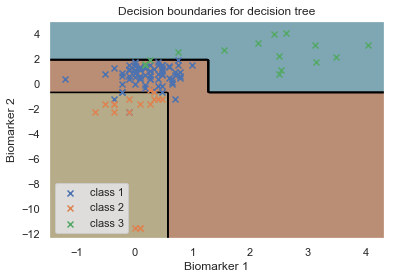

In [45]:
# your code here
for i in range(1,4):
    plt.scatter(data_train[data_train.Diagnosis == i]['Biomarker 1'],
                data_train[data_train.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for decision tree')
ax = plt.axes()
overlay_decision_boundary(ax, model_tree)

**your answer here**


**5.3** Describe how each model classifies an observation from the test set in one short sentence for each (assume that the model is already fit). For example, for the linear regression classifier you critiqued in hw5, you might write: "It classifies the observation as class 1 if the dot product of the feature vector with the the model coefficients (with constant added) exceeds 0.5."

- Logistic Regression (One-vs-Rest)

It classifies the observation as class 1 if the logit transform of the dot product between the feature vector and the the model coefficients (with constant added) exceeds 0.5

- Linear Discriminant Analysis

It classifies the observation as class 1 if the pdf of the class 1 normal distribution evaluated at the the feature vector is greater than all the other classes'.

- Quadratic Discriminant Analysis

It classifies the observation as class 1 if the pdf of the class 1 normal distribution evaluated at the the feature vector is greater than all the other classes'.

- k-Nearest-Neighbors Classifier

It classifies the observation as class 1 if the k nearest points to the observation in the training set are majority class 1.

- Decision Tree

It classifies the observation as class 1 if, by following the rules dictated by the tree, you end in a class 1 leaf.

**Your answer here**


**5.4**

In [46]:
# your code here
models = [model_lin, model_quad, model_LDA, model_QDA, model_knn, model_tree]
acc = []
for m in models:
    acc.append(np.mean(cross_val_score(m, X, y, cv = 5)))
validation_scores = pd.DataFrame({'model':['logistic reg. (linear)', 
                                           'logist reg. (quadratic)',
                                           'LDA',
                                           'QDA',
                                           'KNN',
                                           'tree'],
                                  'cross validation score':acc
                                 })
validation_scores

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option

,model,cross validation score
0,logistic reg. (linear),0.916883
1,logist reg. (quadratic),0.897403
2,LDA,0.850649
3,QDA,0.887879
4,KNN,0.916450
5,tree,0.916450


**Your answer here**


**5.5**

I would expect logistic regression to perform best because it has the highest cross validation performance and the decision boundaries are simple, which might help with generalization. 

In [47]:
# your code here
# your code here
models = [model_lin, model_quad, model_LDA, model_QDA, model_knn, model_tree]
acc = []
X_test = data_test.values[:,:-1]
y_test = data_test.values[:,-1]
for m in models:
    acc.append(accuracy_score(y_test, m.predict(X_test)))
validation_scores = pd.DataFrame({'model':['logistic reg. (linear)', 
                                           'logist reg. (quadratic)',
                                           'LDA',
                                           'QDA',
                                           'KNN',
                                          'tree'],
                                  'test set score':acc
                                 })
validation_scores

,model,test set score
0,logistic reg. (linear),0.842593
1,logist reg. (quadratic),0.851852
2,LDA,0.814815
3,QDA,0.851852
4,KNN,0.851852
5,tree,0.833333


/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


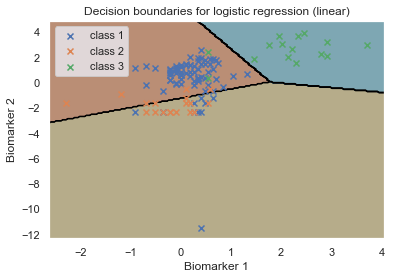

In [48]:
# your code here
# Your code here
for i in range(1,4):
    plt.scatter(data_test[data_test.Diagnosis == i]['Biomarker 1'],
                data_test[data_test.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for logistic regression (linear)')
ax = plt.axes()
overlay_decision_boundary(ax, model_lin, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


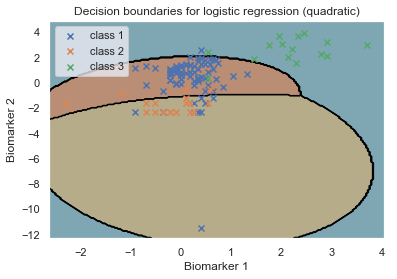

In [49]:
# your code here
# Your code here
for i in range(1,4):
    plt.scatter(data_test[data_test.Diagnosis == i]['Biomarker 1'],
                data_test[data_test.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for logistic regression (quadratic)')
ax = plt.axes()
overlay_decision_boundary(ax, model_quad, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


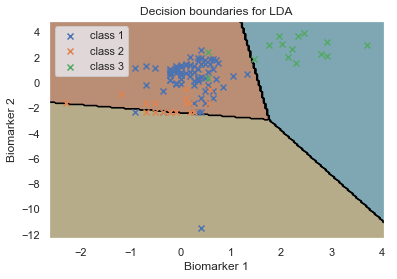

In [50]:
# your code here
# Your code here
for i in range(1,4):
    plt.scatter(data_test[data_test.Diagnosis == i]['Biomarker 1'],
                data_test[data_test.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for LDA')
ax = plt.axes()
overlay_decision_boundary(ax, model_LDA, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


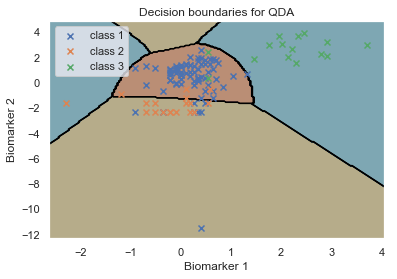

In [51]:
# your code here
# Your code here
for i in range(1,4):
    plt.scatter(data_test[data_test.Diagnosis == i]['Biomarker 1'],
                data_test[data_test.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for QDA')
ax = plt.axes()
overlay_decision_boundary(ax, model_QDA, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


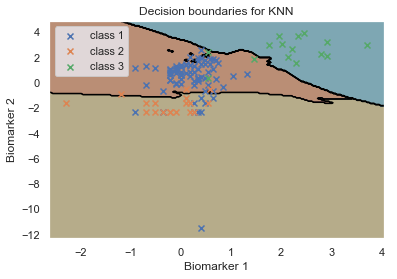

In [52]:
# your code here
# Your code here
for i in range(1,4):
    plt.scatter(data_test[data_test.Diagnosis == i]['Biomarker 1'],
                data_test[data_test.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for KNN')
ax = plt.axes()
overlay_decision_boundary(ax, model_knn, colors=None, nx=200, ny=200, desaturate=.5)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


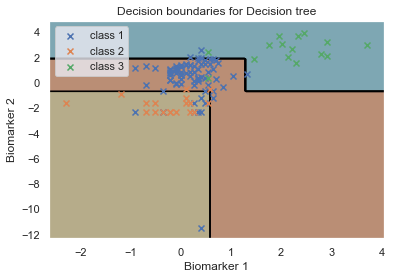

In [53]:
# your code here
# Your code here
for i in range(1,4):
    plt.scatter(data_test[data_test.Diagnosis == i]['Biomarker 1'],
                data_test[data_test.Diagnosis == i]['Biomarker 2'] ,
                marker='x',
                label = 'class {}'.format(i)
               )
plt.legend()
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.title('Decision boundaries for Decision tree')
ax = plt.axes()
overlay_decision_boundary(ax, model_tree, colors=None, nx=200, ny=200, desaturate=.5)

**your answer here**

**How did the overall performance compare with your performance estimates above?**

The performance estimates did not match the actual performance well.

**Which model actually performed best? **

KNN, QDA, and the quadratic logistic regression performed equally well.

**Why do you think this is the case?**

The true decision boundary is likely nonlinear, causing these models to generalize better.

**5.6**

**5.6**. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):

|criteria|Logistic Regression (linear)|Logistic Regression (quadratic)|LDA|QDA|KNN|Decision Tree|
|---|---|---|---|---|---|---|
|performance|0.84|0.85|0.81|0.85|0.85|TBD
|complexity|linear|quadratic|linear|quadratic|non-linear|non-linear
|memory|O($\text{features} \times \text{class}$)|O($\text{features}^2 \times \text{class}$)|O($\text{features} \times \text{class}$)|O($\text{features}^2 \times \text{class}$)|O($\text{features} \times \text{samples}$)| O($2^{\text{tree depth}})$)
|interpretable| yes | yes| yes| yes| no | yes| 

If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.

I would prefer to use QDA because it has one of the highest performances, has high interpretability, and we can easily identify samples in areas of the feature space for which we have minimal data (which is critical in a healthcare setting because we need to understand the uncertainty associated with our predictions).

<div class='exercise'><b> Question 6: [2 pts] Including an 'abstain' option </b></div>
**Note this question is only worth 2 pts. **

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost.  How could one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.



**6.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is 5000, and the cost incurred when the model abstains from making a prediction is 1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 2? Note that this needs to be evaluated on the patients in the test set. 

**6.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.



**6.1**

**Your answer here**


In [54]:
# your code here


In [55]:
# your code here


**6.2**

**Your answer here**
